# compute_spec.ipynb

This notebook takes earthquake seismograms (multiple miniseed files per event) as input, and does the following:

1) Estimate P-wave arrival time using a pre-computed travel-time table based on a 1D velocity model
2) Window the seismogram around the arrival, using the pre-arrival window as a noise window and the post-arrival window as the signal window
3) Detrend the combined noise and signal window
4) Test signal-to-noise (STN) ratio based on time-domain amplitude of each window, and toss records with poor STN
5) Resample to a given sampling rate
6) Compute the spectra of both windows using multitapers (Prieto, 2022)
7) Correct to displacement units from velocity or acceleration in the frequency domain
8) Save the resulting information in .spec files (one per earthquake)

After this, the next step is running spectral_decomposition.ipynb


In [583]:
import numpy as np 
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
from geopy.distance import geodesic

from lib.EFSpy_module import EFS
from tqdm import tqdm, trange
import copy
import time
from multitaper import MTSpec, mtspec
import struct

In [584]:
def write_spec(filepath, ehead, shead, spec, prec_wf='float32', prec_bp='int32'):
    """Reciprocal function to readspec. Writes spectrum and associated 
    information to a .spec file. Follows Peter Shearer's .spec file 
    format.

    Args:
        filepath (str): Path of the .spec file to generate
        shead (_type_): Spectral method header info dict object. Should
            contain ispec_method, ntwind, nf, twindoff, dt, and df.
        spec (_type_): _description_
        prec_wf (str, optional): _description_. Defaults to 'float32'.
        prec_bp (str, optional): _description_. Defaults to 'int32'.

    Sources:

    Last Modified:
        2023-10-30
    """

    with open(filepath, 'wb') as f:
        # Write junk and shead
        f.write(struct.pack('i', 0))  # Junk
        f.write(struct.pack('i', shead['ispec_method']))
        f.write(struct.pack('i', shead['ntwind']))
        f.write(struct.pack('i', shead['nf']))
        f.write(struct.pack('f', shead['twindoff']))
        f.write(struct.pack('f', shead['dt']))
        f.write(struct.pack('f', shead['df']))
        
        # Write junk and ehead
        f.write(struct.pack('ii', 0, 0))  # Junk
        f.write(struct.pack('40s', ehead['efslabel'].encode('UTF-8')))
        f.write(struct.pack('40s', ehead['datasource'].encode('UTF-8')))
        f.write(struct.pack('i', ehead['maxnumts']))
        f.write(struct.pack('i', ehead['numts']))
        f.write(struct.pack('i', ehead['cuspid']))
        f.write(struct.pack('4s', ehead['qtype'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmag1type'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmag2type'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmag3type'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qmomenttype'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qlocqual'].encode('UTF-8')))
        f.write(struct.pack('4s', ehead['qfocalqual'].encode('UTF-8')))
        f.write(struct.pack('f', ehead['qlat']))
        f.write(struct.pack('f', ehead['qlon']))
        f.write(struct.pack('f', ehead['qdep']))
        f.write(struct.pack('f', ehead['qsc']))
        f.write(struct.pack('f', ehead['qmag1']))
        f.write(struct.pack('f', ehead['qmag2']))
        f.write(struct.pack('f', ehead['qmag3']))
        f.write(struct.pack('f', ehead['qmoment']))
        f.write(struct.pack('f', ehead['qstrike']))
        f.write(struct.pack('f', ehead['qdip']))
        f.write(struct.pack('f', ehead['qrake']))
        f.write(struct.pack('i', ehead['qyr']))
        f.write(struct.pack('i', ehead['qmon']))
        f.write(struct.pack('i', ehead['qdy']))
        f.write(struct.pack('i', ehead['qhr']))
        f.write(struct.pack('i', ehead['qmn']))

        # Write 20 4-byte fields reserved for future uses
        for _ in range(20):
            f.write(struct.pack('i', 0))

        # Write time series data
        for wv in spec:
            f.write(struct.pack('ii', 3, 1))  # Junk
            f.write(struct.pack('8s', wv['stname'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['loccode'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['datasource'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['sensor'].encode('UTF-8')))
            f.write(struct.pack('8s', wv['units'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['chnm'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['stype'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['dva'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick1q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick2q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick3q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick4q'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick1name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick2name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick3name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['pick4name'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['ppolarity'].encode('UTF-8')))
            f.write(struct.pack('4s', wv['problem'].encode('UTF-8')))
            f.write(struct.pack('i', wv['npts']))
            f.write(struct.pack('i', wv['syr']))
            f.write(struct.pack('i', wv['smon']))
            f.write(struct.pack('i', wv['sdy']))
            f.write(struct.pack('i', wv['shr']))
            f.write(struct.pack('i', wv['smn']))
            f.write(struct.pack('f', wv['compazi']))
            f.write(struct.pack('f', wv['compang']))
            f.write(struct.pack('f', wv['gain']))
            f.write(struct.pack('f', wv['f1']))
            f.write(struct.pack('f', wv['f2']))
            f.write(struct.pack('f', wv['dt']))
            f.write(struct.pack('f', wv['ssc']))
            f.write(struct.pack('f', wv['tdif']))
            f.write(struct.pack('f', wv['slat']))
            f.write(struct.pack('f', wv['slon']))
            f.write(struct.pack('f', wv['selev']))
            f.write(struct.pack('f', wv['deldist']))
            f.write(struct.pack('f', wv['sazi']))
            f.write(struct.pack('f', wv['qazi']))
            f.write(struct.pack('f', wv['pick1']))
            f.write(struct.pack('f', wv['pick2']))
            f.write(struct.pack('f', wv['pick3']))
            f.write(struct.pack('f', wv['pick4']))

            # Write 22 4-byte fields reserved for future uses
            for _ in range(22):
                f.write(struct.pack('i', 0))

            # Write the waveform data
            np.array(wv['x1'], dtype=prec_wf).tofile(f)
            np.array(wv['x2'], dtype=prec_wf).tofile(f)
            np.array(wv['s1'], dtype=prec_wf).tofile(f)
            np.array(wv['s2'], dtype=prec_wf).tofile(f)

def load_tt(path):
    """
    Returns distance, depth, and travel time (array, array, matrix)

    Parameters
    ----------
    path : string
        path (including filename) to travel time table.

    Returns
    -------
    X : np.array
        distances.
    Y : np.array
        depths.
    T : np.array
        travel time matrix.

    """
    # these are properties of the tt tables generated by Peter Shearer's fortran codes
    n_head_lines = 3
    n_foot_lines = 1
    n_skip = n_head_lines+n_foot_lines
    
    # open file
    fp = open(path,'r')
    lines = fp.readlines()
    
    # get header lines
    head = lines[0]
    head2 = lines[1]
    
    # get dimensions of T
    nd = np.array(head2.split(),dtype=int)
    nx = nd[0]
    ny = nd[1]
    
    # init arrays
    X = np.array([],dtype=float)
    Y = np.array(lines[n_head_lines-1].split(),dtype=float)
    T = np.zeros((nx,ny),dtype=float)
    
    for ii,line in enumerate(lines[n_head_lines:]):
        ln = np.array(line.split(),dtype=float)
        X = np.append(X,ln[0])
        T[ii,:] = ln[1:]
            
    return X,Y,T

def get_pick_estimate(X, Y, TT, distance, depth, distance_units='km'):
    """Get an estimated pick time for a given event-station distance 
    and event depth using a travel time table.

    This is designed to interpolate travel times from Peter's traveltime
    codes. X, Y, and TT are np.ndarray objects output from the load_tt()
    function in stressdrop_file_IO.py. See interpolate_grid() for more 
    detailed information.

    Args:
        X (np.ndarray): Distance spacing array
        Y (np.ndarray): Depth spacing array
        TT (np.ndarray): Estimated travel times for given X and Y points
        distance (float): Event-station distance (km or degrees)
        depth (float): Event depth (km)
        distance_units (str, optional): Distance units, either 'km' or 
            'degrees'. Defaults to 'km'.

    Returns:
        Tinterp (float): Estimated travel time

    Sources:

    Last Modified:
        2024-02-06
    """

    dx = X[1] - X[0]
    dy = Y[1] - Y[0]

    if distance_units=='degrees':
        from obspy.geodetics import degrees2kilometers
        distance = degrees2kilometers(distance)
    
    try:
        # get indices of the element to the left of the value in the X and Y
        # directions. Ex: for X = [0, 1, 2, 3] and distance = 1.12, ix = 1
        ix = np.abs(X - distance).argmin()
        iy = np.abs(Y - depth).argmin()
        if distance < (ix * dx): ix -= 1
        if depth <= (iy * dy): iy -= 1

        # get left and right element relative to actual value
        xx = X[ix:ix+2]
        yy = Y[iy:iy+2]
        
        # get 4 elements surrounding actual value
        tt = TT[ix:ix+2,iy:iy+2]

        # notation: T0p: T at x[0], Yp or T(x[0], Yp)
        # Tij = T(xi, yj)
        T0p = ((tt[0,1]-tt[0,0]) / dy ) * (depth - yy[0]) + tt[0,0] #top
        T1p = ((tt[1,1]-tt[1,0]) / dy ) * (depth - yy[0]) + tt[1,0] #bottom
        Tp0 = ((tt[1,0]-tt[0,0]) / dx ) * (distance - xx[0]) + tt[0,0] #left
        Tp1 = ((tt[1,1]-tt[0,1]) / dx ) * (distance - xx[0]) + tt[0,1] #right

        # interpolate along midlines
        Tpx = ((T1p - T0p)/ dx ) * (distance - xx[0]) + T0p
        Tpy = ((Tp1 - Tp0)/ dy ) * (depth - yy[0]) + Tp0
        
        Tinterp = (Tpx+Tpy)/2
    except Exception as E:
        print(E)
        print(f"depth: {depth:.2f}")
        print(f"distance: {distance:.2f}")
        print(f"xx: {xx}")
        print(f"yy: {yy}")
        print(f"tt: {tt}")
        Tinterp = -99999.0
    return Tinterp


## Parameters

Change the windowing parameters here. Below is an example of how windowing works.

![windowing](figures/windowing.pdf "Windowing example")

A few notes:
1) The offset between t_pick and t0 (equal in magnitude to 'twindoff') is to account for error in the estimated arrival times and hopefully capture the entire P-wave arrival in the signal window
2) The noise and signal window are of equal length, with t0 marking the point in between them.
3) Spectra are converted into displacement in the frequency domain by division:
\begin{equation}
S_{disp}(f) = S_{vel}(f) / (2 \pi f)
\end{equation}
While this results in a NaN value for the first point (where $f=0$), this point is generally thrown out anyways. So, in this case I set the first frequency point to a non-zero value to supress the error
4) Here, I compute signal-to-noise in the time domain. If computing in the frequency-domain, be careful not to bias results by choosing too high of a frequency band. See **Shearer and Abercrombie (2021)** for more information.

In [585]:
# Spectral computation parameters
window_length   = 1.5       # length of the signal and noise windows (s)
resample_rate   = 100.0     # Hz
twindoff        = -0.05     # Signal window offset relative to arrival time (s)
tdif            = -30.0     # Seismogram start time relative to origin time (s)
stn_req         = 3.0       # Required signal-to-noise ratio to keep records

# Relevant directories
seismogram_parent_folder = "data/raw_seismograms/"
spec_dir = "data/spec_files/"

Compute spectra properties

In [586]:
nt = int(window_length * resample_rate)
dt = 1 / resample_rate
nf = int(nt + 1)
df = Fn / (nf-1)
Fn = resample_rate / 2

f = np.linspace(0, Fn, nf)

print("Time series and spectra info:")
print("---------------------------------------")
print(f"Sampling rate:                 {resample_rate} Hz")
print(f"Window length:                 {window_length:.2f} sec")
print(f"dt:                            {dt:.2f} sec")
print(f"Samples/window (nt):           {nt}")
print(f"Samples/frequency window (nf): {nf}")
print(f"df:                            {df:.3f} Hz")
print(f"Nyquist frequency:             {Fn:.1f} Hz")



Time series and spectra info:
---------------------------------------
Sampling rate:                 100.0 Hz
Window length:                 1.50 sec
dt:                            0.01 sec
Samples/window (nt):           150
Samples/frequency window (nf): 151
df:                            0.333 Hz
Nyquist frequency:             50.0 Hz


### Load velocity model for pick estimation

This is a basic method of estimating picks, using the following algorithm:
1) Import a 1D velocity model of the study region
2) Compute a travel-time table for set distance and depth combinations
3) Estimate pick times using distance and depth, interpolating the travel-time table data

A number of improvements could be made here:
1) To simplify, I have completely ignored topography. This is more than likely a large source of error in computing pick times.
2) The velocity table below is calculated using a 1D velocity model. Any heterogeneity will cause error in the estimated pick time. 
3) Catalog pick times exist for some events, but I do not use them here.

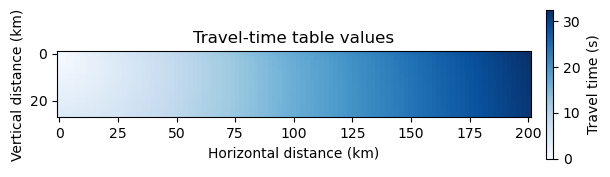

In [587]:
X, Z, TT = load_tt('data/tt_table/ttsocal2.pg')

plt.figure()
# im = plt.imshow(TT.T, cmap='Blues', interpolation='none', extent=[])
im = plt.pcolor(X,Z,TT.T, cmap='Blues')
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.xlabel("Horizontal distance (km)")
plt.ylabel("Vertical distance (km)")
plt.title("Travel-time table values")
cb = plt.colorbar(im, fraction=0.015, pad=0.03)
cb.ax.set_ylabel("Travel time (s)")
# plt.savefig("figures/traveltimetable.pdf", bbox_inches='tight')
plt.show()

Read previously saved event and station lists

In [588]:
inv = pd.read_csv('data/station_list.txt', keep_default_na=False)
inv['stid'] = inv['net'] + '.' + inv['sta'] + '.' + inv['loc'] + '.' + inv['cha']

cat = pd.read_csv('data/event_list.txt')
print(f"{len(inv)} stations loaded")
print(f"{len(cat)} events loaded")

192 stations loaded
7297 events loaded


7298 events found


Computing spectra:   0%|          | 0/7298 [00:00<?, ?it/s]

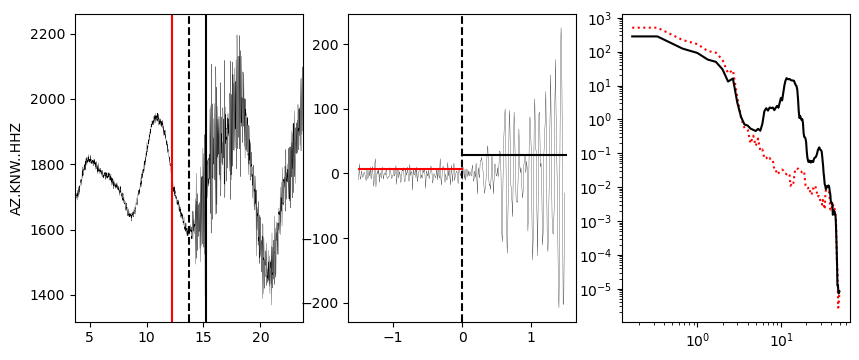

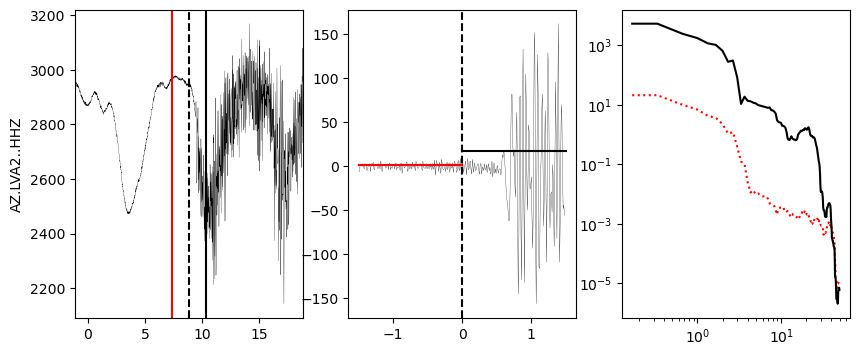

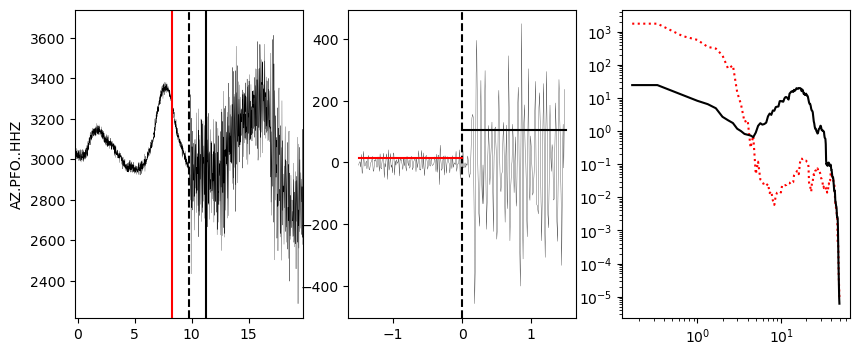

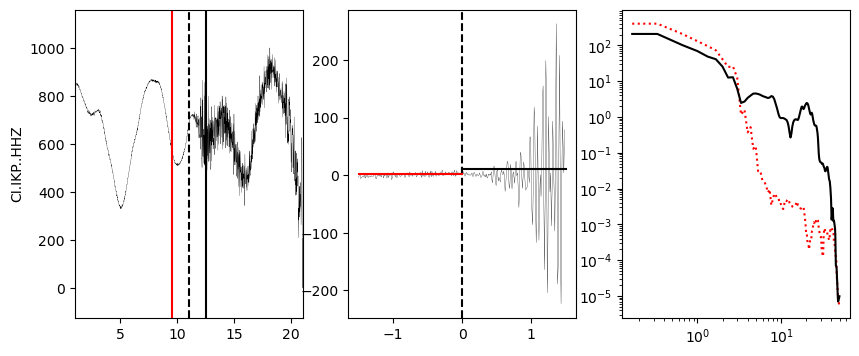

Computing spectra:   3%|▎         | 189/7298 [00:55<29:50,  3.97it/s] /Users/ivandevert/miniconda3/envs/specdecomp/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivandevert/miniconda3/envs/specdecomp/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Computing spectra:   6%|▋         | 460/7298 [01:58<28:17,  4.03it/s]  

index 1 is out of bounds for axis 1 with size 0
depth: 0.00
distance: 27.47
xx: [26. 28.]
yy: []
tt: []


Computing spectra:  44%|████▍     | 3205/7298 [10:33<07:08,  9.55it/s]

index 1 is out of bounds for axis 1 with size 1
depth: 30.19
distance: 103.72
xx: [102. 104.]
yy: [26.]
tt: [[16.6036]
 [16.9037]]
index 1 is out of bounds for axis 1 with size 1
depth: 30.05
distance: 97.79
xx: [96. 98.]
yy: [26.]
tt: [[15.7044]
 [16.0035]]
index 1 is out of bounds for axis 1 with size 1
depth: 30.32
distance: 93.20
xx: [92. 94.]
yy: [26.]
tt: [[15.1072]
 [15.4058]]
index 1 is out of bounds for axis 1 with size 1
depth: 30.15
distance: 87.59
xx: [86. 88.]
yy: [26.]
tt: [[14.2131]
 [14.5102]]
index 1 is out of bounds for axis 1 with size 1
depth: 30.25
distance: 99.80
xx: [ 98. 100.]
yy: [26.]
tt: [[16.0035]
 [16.3036]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.52
distance: 82.13
xx: [82. 84.]
yy: [26.]
tt: [[13.6187]
 [13.9159]]
index 1 is out of bounds for axis 1 with size 1
depth: 29.08
distance: 108.54
xx: [108. 110.]
yy: [26.]
tt: [[17.5039]
 [17.804 ]]
index 1 is out of bounds for axis 1 with size 1
depth: 30.17
distance: 101.00
xx: [100. 102.]
yy

Computing spectra:  50%|████▉     | 3628/7298 [11:43<11:09,  5.48it/s]

index 1 is out of bounds for axis 1 with size 1
depth: 27.01
distance: 64.03
xx: [64. 66.]
yy: [26.]
tt: [[10.9774]
 [11.2675]]
index 1 is out of bounds for axis 1 with size 1
depth: 26.84
distance: 73.34
xx: [72. 74.]
yy: [26.]
tt: [[12.1438]
 [12.4377]]
index 1 is out of bounds for axis 1 with size 1
depth: 26.87
distance: 58.64
xx: [58. 60.]
yy: [26.]
tt: [[10.114 ]
 [10.4005]]
index 1 is out of bounds for axis 1 with size 1
depth: 27.22
distance: 80.07
xx: [80. 82.]
yy: [26.]
tt: [[13.3229]
 [13.6187]]
index 1 is out of bounds for axis 1 with size 1
depth: 27.14
distance: 50.24
xx: [50. 52.]
yy: [26.]
tt: [[8.984 ]
 [9.2636]]
index 1 is out of bounds for axis 1 with size 1
depth: 26.97
distance: 54.84
xx: [54. 56.]
yy: [26.]
tt: [[9.5454]
 [9.8289]]
index 1 is out of bounds for axis 1 with size 1
depth: 27.07
distance: 85.72
xx: [84. 86.]
yy: [26.]
tt: [[13.9159]
 [14.2131]]
index 1 is out of bounds for axis 1 with size 1
depth: 26.07
distance: 108.11
xx: [108. 110.]
yy: [26.]
tt: 

Computing spectra:  72%|███████▏  | 5255/7298 [15:56<06:24,  5.31it/s]

index 1 is out of bounds for axis 1 with size 1
depth: 26.50
distance: 102.65
xx: [102. 104.]
yy: [26.]
tt: [[16.6036]
 [16.9037]]


Computing spectra:  75%|███████▌  | 5494/7298 [16:38<04:08,  7.26it/s]

index 1 is out of bounds for axis 1 with size 1
depth: 26.64
distance: 105.83
xx: [104. 106.]
yy: [26.]
tt: [[16.9037]
 [17.2038]]


Computing spectra:  83%|████████▎ | 6021/7298 [18:12<04:55,  4.33it/s]

index 1 is out of bounds for axis 1 with size 1
depth: 28.21
distance: 78.38
xx: [78. 80.]
yy: [26.]
tt: [[13.0271]
 [13.3229]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.04
distance: 87.71
xx: [86. 88.]
yy: [26.]
tt: [[14.2131]
 [14.5102]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.07
distance: 73.01
xx: [72. 74.]
yy: [26.]
tt: [[12.1438]
 [12.4377]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.42
distance: 94.16
xx: [94. 96.]
yy: [26.]
tt: [[15.4058]
 [15.7044]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.34
distance: 64.21
xx: [64. 66.]
yy: [26.]
tt: [[10.9774]
 [11.2675]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.79
distance: 61.26
xx: [60. 62.]
yy: [26.]
tt: [[10.4005]
 [10.6884]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.17
distance: 68.66
xx: [68. 70.]
yy: [26.]
tt: [[11.5589]
 [11.8509]]
index 1 is out of bounds for axis 1 with size 1
depth: 28.27
distance: 100.09
xx: [100. 102.]
yy: [26.]


Computing spectra:  99%|█████████▉| 7211/7298 [21:36<00:10,  8.18it/s]

index 1 is out of bounds for axis 1 with size 1
depth: 31.32
distance: 89.34
xx: [88. 90.]
yy: [26.]
tt: [[14.5102]
 [14.8086]]
index 1 is out of bounds for axis 1 with size 1
depth: 30.17
distance: 99.01
xx: [ 98. 100.]
yy: [26.]
tt: [[16.0035]
 [16.3036]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.15
distance: 99.81
xx: [ 98. 100.]
yy: [26.]
tt: [[16.0035]
 [16.3036]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.18
distance: 85.83
xx: [84. 86.]
yy: [26.]
tt: [[13.9159]
 [14.2131]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.45
distance: 71.21
xx: [70. 72.]
yy: [26.]
tt: [[11.8509]
 [12.1438]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.89
distance: 35.14
xx: [34. 36.]
yy: [26.]
tt: [[6.8492]
 [7.1027]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.28
distance: 90.05
xx: [90. 92.]
yy: [26.]
tt: [[14.8086]
 [15.1072]]
index 1 is out of bounds for axis 1 with size 1
depth: 31.38
distance: 91.54
xx: [90. 92.]
yy: [26.]
t

Computing spectra: 100%|█████████▉| 7297/7298 [21:52<00:00,  5.56it/s]


ValueError: invalid literal for int() with base 10: 'archive_mammoth'

In [589]:
show_plots = True
nexamples = 3

event_ids = [el for el in os.listdir(seismogram_parent_folder) if not el.startswith('.')]
event_ids.remove('archive')
event_ids.sort()
print(f"{len(event_ids)} events found")

completed_spec_ids = [int(el.split('.')[0]) for el in os.listdir('data/spec_files/') if el.endswith('.spec')]
if len(completed_spec_ids) > 0:
    event_ids = [el for el in event_ids if int(el) not in completed_spec_ids]
    print(f"{len(completed_spec_ids)} already completed. Skipping these.")

# required dict for write_spec()
shead = {
    'ispec_method': 11,
    'ntwind': nt,
    'nf': nf,
    'twindoff': twindoff,
    'dt': dt,
    'df': df
}


nex = 0
# loop over each folder
for i in trange(len(event_ids), desc='Computing spectra: '):
# for i in range(100):
    event_id = int(event_ids[i])
    # print(event_id)


    # load miniseeds
    seis_path = seismogram_parent_folder + str(event_id) + "/"
    seis_files = [el for el in os.listdir(seis_path) if el.endswith('.mseed')]
    nfiles = len(seis_files)

    if nfiles > 0:
        st = obspy.core.stream.read(seis_path + "*.mseed", format="MSEED")

        # find the event_id in cat object to get information
        ev = cat.iloc[np.where(cat['event_id'].values==int(event_id))[0][0]]

        qdep = ev['qdep']

        # # Some depths are negative (due to topography?). Toss these.
        # if ev['qdep'] > 0:

        # setup plots
        # if show_plots:
        #     nplt = 0
        #     fig, axs = plt.subplots(ncols=3, nrows=nfiles, figsize=(6, 2*nfiles),
        #         layout='constrained')
        
        # for j in range(nfiles):
        #     axs[j,0].plot(st[j].times()+tdif, st[j].data, c='k', linewidth=0.2)

        # split origin time string
        tA, tB = ev.origin_time.split(' ')
        ymd = tA.split('-')
        hms = tB.split(':')

        ehead = {
            'efslabel': '',
            'datasource': '',
            'maxnumts': len(st),
            'cuspid': int(event_id),
            'qtype': '',
            'qmag1type': ev['qmagtype'],
            'qmag2type': '',
            'qmag3type': '',
            'qmomenttype': '',
            'qlocqual': '',
            'qfocalqual': '',
            'qlat': ev['qlat'],
            'qlon': ev['qlon'],
            'qdep': ev['qdep'],
            'qsc': float(hms[2]),
            'qmag1': ev['qmag'],
            'qmag2': 0.0,
            'qmag3': 0.0,
            'qmoment': 0.0,
            'qstrike': 0.0,
            'qdip': 0.0,
            'qrake': 0.0,
            'qyr':  int(ymd[0]),
            'qmon': int(ymd[1]),
            'qdy':  int(ymd[2]),
            'qhr':  int(hms[0]),
            'qmn':  int(hms[1]),
            'numts': 0
        }
        
        # spec is a list of dicts
        spec = []
        for j, tr in enumerate(st):
            len_tr_init = len(tr)

            # calculate station-event distances
            sta = inv.iloc[np.where(inv['stid']==tr.id)[0][0]]
            deldist = geodesic((ev['qlat'], ev['qlon']), (sta['slat'], sta['slon'])).km

            # dt*: UTCDateTime objects - exact time
            # t*:  time in seconds relative to origin time
            
            sele = sta['sele'] / 1000

            deldepth = abs(sele + qdep)

            # estimate travel time
            t_pick = get_pick_estimate(X, Z, TT, deldist, deldepth, distance_units='km')

            # store initial time series, relative to origin time
            t_init = tr.times() + tdif
            x_init = tr.data

            dt_arrival = tr.stats.starttime - tdif + t_pick

            # Time of signal window start
            t0 = t_pick + twindoff

            # if trace's sample rate is close to the desired rate, select window
            # directly
            if np.isclose(tr.stats.sampling_rate, resample_rate):
                # UTCDateTime exact time of estimated arrival
                tr.trim(starttime=dt_arrival - (window_length + abs(twindoff)) + dt,
                        endtime=dt_arrival + (window_length - abs(twindoff)))
            else:
                # do a rough window to speed up resample()
                tr.trim(starttime=dt_arrival - (window_length + abs(twindoff)),
                        endtime=dt_arrival + (window_length + abs(twindoff)))

                # resample, then trim to exact size
                tr.resample(resample_rate)
                tr.trim(starttime=dt_arrival - (window_length + abs(twindoff)) + dt,
                        endtime=dt_arrival + (window_length - abs(twindoff)))


            tr.detrend(type='demean')

            x1 = tr.data[:nt]
            x2 = tr.data[nt:]

            # t relative to t0
            t = tr.times()[:-1] - window_length

            s_amp = np.median(np.abs(np.diff(x2)))
            n_amp = np.median(np.abs(np.diff(x1)))
            stn = np.median(np.abs(np.diff(x2))) / np.median(np.abs(np.diff(x1)))
            # print(stn)
            # check the signal to noise ratio. np.diff stabilizes low frequency trends
            if stn >= stn_req:

                # Compute spectra
                f1, s1 = MTSpec(x1, dt=dt).rspec()
                f2, s2 = MTSpec(x2, dt=dt).rspec()
                f1 = f1.flatten()
                f2 = f2.flatten()
                s1 = s1.flatten()
                s2 = s2.flatten()

                # not 'correct', but suppresses errors (see note above)
                f1[0] = f1[1] / 2
                f2[0] = f2[1] / 2

                # correct to displacement
                if sta['units'].lower()=='m/s':
                    s1 = s1 / (2 * np.pi * f1)
                    s2 = s2 / (2 * np.pi * f2)
                    s1[0] = s1[1]
                    s2[0] = s2[1]
                elif sta['units'].lower()=='m/s**2':
                    s1 = s1 / ((2 * np.pi * f1)**2)
                    s2 = s2 / ((2 * np.pi * f2)**2)
                    s1[0] = s1[1]
                    s2[0] = s2[1]

                # Make example plots of passing records
                if show_plots and stn >= stn_req and nex <= nexamples:
                    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
                    axs[0].plot(t_init, x_init, c='k', linewidth=0.2)
                    axs[0].axvline(t0, c='k', linestyle='--')
                    axs[0].axvline(t0-window_length, c='r')
                    axs[0].axvline(t0+window_length, c='k')
                    axs[0].set_xlim([t0-10, t0+10])
                    axs[0].set_ylabel(sta['stid'])

                    axs[1].plot(t, np.diff(tr.data), c='k', linewidth=0.2)
                    axs[1].axvline(0, c='k', linestyle='--')
                    axs[1].plot([0,window_length], [s_amp, s_amp], c='k')
                    axs[1].plot([-window_length,0], [n_amp, n_amp], c='r')

                    axs[2].plot(f1, s1, c='r', linestyle=':')
                    axs[2].plot(f2, s2, c='k')

                    axs[2].set_xscale('log')
                    axs[2].set_yscale('log')
                    plt.show()
                    nex += 1

                # write to .spec files
                sp = {
                    'stname': sta['sta'],
                    'loccode': sta['loc'],
                    'datasource': '',
                    'sensor': '',
                    'units': sta['units'], 
                    'chnm': sta['cha'],
                    'stype': sta['net'],
                    'dva': '',
                    'pick1q': '',
                    'pick2q': '',
                    'pick3q': '',
                    'pick4q': '',
                    'pick1name': '',
                    'pick2name': '',
                    'pick3name': '',
                    'pick4name': '',
                    'ppolarity': '',
                    'problem': '',
                    'npts': len_tr_init,
                    'syr': 0,
                    'smon': 0,
                    'sdy': 0,
                    'shr': 0,
                    'smn': 0,
                    'compazi': -99.0,
                    'compang': -99.0,
                    'gain': 1.0,
                    'f1': -1.0,
                    'f2': -1.0,
                    'dt': resample_rate,
                    'ssc': 0,
                    'tdif': tdif,
                    'slat': sta['slat'],
                    'slon': sta['slon'],
                    'selev': sta['sele'],
                    'deldist': deldist,
                    'sazi': 0,
                    'qazi': 0,
                    'pick1': t_pick,
                    'pick2': 0.0,
                    'pick3': 0.0,
                    'pick4': -99.0,
                    'x1': x1,
                    'x2': x2,
                    's1': s1,
                    's2': s2
                }
                spec.append(sp)
        ehead['numts'] = len(spec)

        # toss events with less than 3 remaining records
        if len(spec) >= 3:
            write_spec(spec_dir+str(event_id)+".spec", ehead, shead, spec)


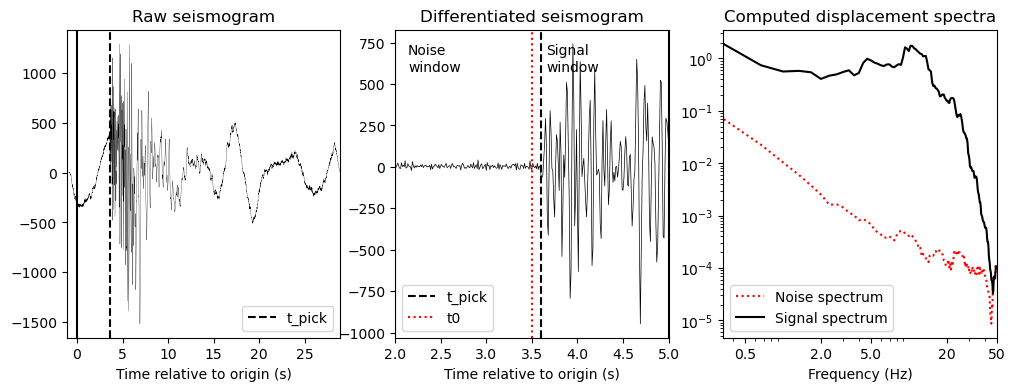

In [504]:
# Make an example plot of windowing and spectrum calculation

tr = obspy.read()[0]

# times relative to "origin" time
tdif = -1.1
t_pick = 3.6
window_width = 1.5
twindoff = -0.1
nt = 150

t0 = t_pick + twindoff

t = tr.times()[:-1] + tdif

inds = [np.argmin(np.abs(t - el)) for el in [t0-window_width, t0+window_width]]

# data is velocity, x is acceleration (not exactly, but units of acc)
x = np.diff(tr.data)
xs = x[inds[0]:inds[1]]

f1, s1 = MTSpec(xs[:nt], dt=0.01).rspec()
f2, s2 = MTSpec(xs[nt:], dt=0.01).rspec()
f1 = f1.flatten()
f2 = f2.flatten()
s1 = s1.flatten()
s2 = s2.flatten()
# not 'correct', but suppresses errors
f1[0] = f1[1] / 2
f2[0] = f2[1] / 2

s1 /= (2*np.pi*f1)**2
s2 /= (2*np.pi*f2)**2
s1[0] = s1[1]
s2[0] = s2[1]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axs[0].plot(tr.times()+tdif, tr.data, c='k', linewidth=0.2)
axs[0].axvline(t_pick, c='k', linestyle='--', label='t_pick')
axs[0].axvline(0, c='k')
axs[0].set_xlim([min(t), max(t)])
axs[0].legend(loc='lower right')
axs[0].set_title('Raw seismogram')

axs[1].plot(t, x, c='k', linewidth=0.5)
axs[1].axvline(t_pick, c='k', linestyle='--', label='t_pick')
axs[1].axvline(t0, c='r', linestyle=':', label='t0')
axs[1].axvline(t0-window_width, c='r')
axs[1].axvline(t0+window_width, c='k')
axs[1].set_xlim([t0-window_width, t0+window_width])
axs[1].annotate('Noise\nwindow', xy=(0.34, 0.80), xycoords='figure fraction')
axs[1].annotate('Signal\nwindow', xy=(0.455, 0.80), xycoords='figure fraction')
axs[1].legend(loc='lower left')
axs[1].set_title('Differentiated seismogram')

axs[2].plot(f1, s1, c='r', linestyle=':', label='Noise spectrum')
axs[2].plot(f2, s2, c='k', label='Signal spectrum')
axs[2].legend(loc='lower left')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[0].set_xlabel('Time relative to origin (s)')
axs[1].set_xlabel('Time relative to origin (s)')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_xticks([0.2, 0.5, 2.0, 5.0, 20, 50])
axs[2].set_xticklabels([0.2, 0.5, 2.0, 5.0, 20, 50])
axs[2].set_xlim([df, 50])
axs[2].set_title('Computed displacement spectra')

# plt.savefig("figures/windowing.pdf", bbox_inches="tight")

plt.show()



In [ ]:
# # shift and interpolate velocity model. Only need to run once
# dz = 1.0
# vz = pd.read_csv('data/tt_table/vz.mammoth1', names=['z', 'vp'], sep='\\s+')
# # shift to ground level
# vz['z'] = vz['z'] - np.min(vz['z'])

# zi = np.arange(vz['z'].min(), vz['z'].max() + dz, dz)
# vpi = np.interp(zi, vz['z'], vz['vp'])

# vsi = vpi / 1.719

# with open('data/tt_table/vz.mammoth1f', 'w') as fp:
#     for i in range(len(zi)):
#         fp.write(f"{zi[i]:5.1f} {vpi[i]:4.2f} {vsi[i]:4.2f}\n")

# plt.figure()
# plt.scatter(vz['vp'], vz['z'])
# plt.plot(vpi, zi)
# plt.show()


# References

- Shearer, P. M. and R. E. Abercrombie (2021). Calibrating spectral decomposition of local earthquakes using borehole seismic records - results for the 1992 Big Bear aftershocks in southern California. *Journal of Geophysical Research: Solid Earth* **126**(3), e2020JB020561.
- Prieto, G. A. (2022, March). The multitaper spectrum analysis package in python. *Seismological Research Letters* **93**(3), 1922–1929.
- Bruce R. Julian, A.M. Pitt, G.R. Foulger, Seismic image of a CO2 reservoir beneath a seismically active volcano, *Geophysical Journal International*, Volume 133, Issue 1, April 1998, Pages F7–F10, https://doi.org/10.1046/j.1365-246X.1998.1331540.x